# **Google Drive Authentication**

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset**

In this assignment, we have chosen the Amazon Book Reviews dataset.

### Unzipping the .gz file

Unzipping the .gz file of Amazon Book Reviews Dataset and obtaining the actual JSON file. After that, creating a smaller CSV dataset with the first 50K entries of the original dataset. (No need to run this cell anymore).

In [ ]:
import json, gzip
import pandas as pd

filename = 'drive/My Drive/Semester-2/reviews_Books_5.json.gz'
output = 'drive/My Drive/Semester-2/reviews_Books_50K.csv'
size = 50000

dataset = []
with open(filename, 'rb') as fin:
    gzipped = gzip.GzipFile(fileobj=fin)
    for i in range(size):
        data = json.loads(gzipped.readline())
        dataset.append([data['asin'], data['helpful'], data['overall'], data['reviewText'], data['reviewTime'], data['reviewerID'], data['summary'], data['unixReviewTime']])

df = pd.DataFrame(dataset, columns=['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'summary', 'unixReviewTime'])
df.to_csv(output)
df.head(5)

# **MODULE - 1**

## Loading the actual 50K dataset

This is the smaller unprocessed dataset. Loading this dataset here to preprocess. After preprocessing, we have created another dataset containing the preprocessed reviews.

Run this cell **only once**.

In [ ]:
import os
import pandas as pd

path = 'drive/My Drive/Semester-2/'
df = pd.read_csv(os.path.join(path, 'reviews_Books_50K.csv'))
df.head(5)

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,summary,unixReviewTime
0,0,000100039X,"[0, 0]",5.0,Spiritually and mentally inspiring! A book tha...,"12 16, 2012",A10000012B7CGYKOMPQ4L,Wonderful!,1355616000
1,1,000100039X,"[0, 2]",5.0,This is one my must have books. It is a master...,"12 11, 2003",A2S166WSCFIFP5,close to god,1071100800
2,2,000100039X,"[0, 0]",5.0,This book provides a reflection that you can a...,"01 18, 2014",A1BM81XB4QHOA3,Must Read for Life Afficianados,1390003200
3,3,000100039X,"[0, 0]",5.0,I first read THE PROPHET in college back in th...,"09 27, 2011",A1MOSTXNIO5MPJ,Timeless for every good and bad time in your l...,1317081600
4,4,000100039X,"[7, 9]",5.0,A timeless classic. It is a very demanding an...,"10 7, 2002",A2XQ5LZHTD4AFT,A Modern Rumi,1033948800


## Preprocessing

Steps :

1. **Removing HTML tags** : Reviews may contain html and css markup, which needs to be preprocessed.

2. **Casefolding** : Converting all characters into lower.

3. **Removing punctuations** : Removing the punctuations.

4. **Removing Stopwords of English** : There are stopwords which occur multiple times in any type of document but they usually don't contain any information. So they need to be removed.

5. **Lemmatization** : It is a process of converting terms/tokens into its actual dictionary format. Stemming, which is a heuristic process of chopping the end of a token, takes less time and computations. Stemming could have been performed but later we need to perform POS tagging, where passing the stemmed tokens will not produce any results.

After preprocessing the dataset using above steps, we have created another dataset, so run this cell **only once**.

In [ ]:
import string, nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
from bs4 import BeautifulSoup

lemmatizer = nltk.stem.WordNetLemmatizer()
def preprocess(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")
    for data in soup(['script', 'style']):
        data.decompose()
    text = ' '.join(soup.stripped_strings)
    text = text.lower()
    temp = ""
    for i in text:
        if i in string.punctuation:
            continue
        else:
            temp+=i
    temp = temp.split()
    temp = [w for w in temp if w not in nltk.corpus.stopwords.words('english')]
    for i in range(len(temp)):
        temp[i] = lemmatizer.lemmatize(temp[i])
    return ' '.join(temp)

df['reviewText'] = df['reviewText'].apply(preprocess)
df.to_csv(os.path.join(path, 'review_Books_50K_preprocessed.csv'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Vocabulary

Vocabulary contains the tokens which defines a document in a corpus and not a stopword. We are taking the preprocessed dataset, which contains lemmatized reviews and splitting the reviews into tokens.

From the generated token streams, we are taking the frequency of each token and storing in a form of python dictionary.

In [ ]:
import nltk, os
import pandas as pd
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

tokens = []
path = 'drive/My Drive/Semester-2/'

df = pd.read_csv(os.path.join(path, 'review_Books_50K_preprocessed.csv'))
corpus = ""
for i in range(len(df)):
    corpus += ' '+str(df.loc[i]['reviewText'])
tokens = corpus.split()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


The code snippet below finds **top 10 most frequent terms** from the corpus. These are the non-stopword terms found in the corpus most number of times and hence, these best describe the corpus.

In [ ]:
from collections import defaultdict
vocab = defaultdict(int)
for token in tokens :
    vocab[token] += 1
vocab = {k:v for k,v in sorted(vocab.items(), key=lambda x:x[1], reverse=True)}

for i in list(vocab.keys())[:10]:
    print(f"{i} : {vocab[i]}")

book : 100315
read : 38479
story : 35692
one : 32913
character : 25683
like : 21241
time : 20346
would : 16680
life : 16382
first : 15755


Visualization using Word cloud. The most frequent words are having largest size in the word cloud.

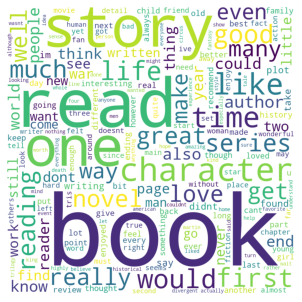

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(height=800, width=800, background_color='white', min_font_size=10).generate_from_frequencies(vocab)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## N-grams

It can be defined as set of co-occuring tokens withing a given window of size=n. Set of n-grams can be formed by taking n consecutive tokens together from a given document.

For example, if the sentence is **'I am a boy'** and **n=2**, then the set will be = **\{('I', 'am'), ('am', 'a'), ('a', 'boy')\}**

In [ ]:
import pandas as pd
import numpy as np
import os

path = 'drive/My Drive/Semester-2/'
df = pd.read_csv(os.path.join(path, 'review_Books_50K_preprocessed.csv'))

def generateNgrams(text, x):
    ng = []
    text = str(text).split()
    for i in range(len(text)-x+1):
        ng.append(text[i:i+x])
    return ng

n = 3
corpus = []
for i in range(len(df)):
    corpus.append(df.loc[i]['reviewText'])

ngram = []
for i in range(len(corpus)):
    ngram.append(generateNgrams(corpus[i], n))
ngram[0]

[['spiritually', 'mentally', 'inspiring'],
 ['mentally', 'inspiring', 'book'],
 ['inspiring', 'book', 'allows'],
 ['book', 'allows', 'question'],
 ['allows', 'question', 'moral'],
 ['question', 'moral', 'help'],
 ['moral', 'help', 'discover'],
 ['help', 'discover', 'really']]

## POS tagging

POS stands for Parts-of-Speech. In English, there are various POS such as Noun, Pronoun, Adjective, Verb etc. From the corpus, we have extracted the POS using ```nltk```'s POS tagger.

Taking the lemmatized tokens from vocabulary and performing POS tagging. Most frequent Noun and Verb are found here.

In [ ]:
tokens_unique = nltk.pos_tag(vocab.keys())
tokens_unique_dict = {tup[0]:tup[1] for tup in tokens_unique}

for n in vocab.keys() :
    if tokens_unique_dict[n] in ['NN','NNB','NNPS','NNP']:
        print(f"Most frequent Noun : {n}")
        break

for v in vocab.keys() :
    if tokens_unique_dict[v] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
        print(f"Most frequent Verb : {v}")
        break

Most frequent Noun : book
Most frequent Verb : read


Finding frequencies of each type of POS

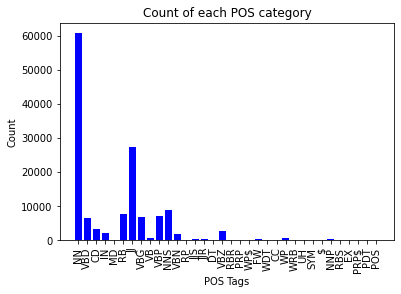

In [ ]:
tags = ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NNS','NNP','NNPS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']
tag_count = defaultdict(int)
for token in tokens_unique:
    tag_count[token[1]]+=1

import matplotlib.pyplot as plt
xval = range(1, 1+len(tag_count.keys()))
plt.bar(xval, tag_count.values(), color='blue')
plt.xlabel('POS Tags')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.xticks(xval, tag_count.keys())
plt.title('Count of each POS category')
plt.show()

## NER

NER stands for Named Entity Recognition. Among the tokens, named entities will be those which are Proper Nouns, i.e. denoting a particular person, place, country, product etc. Here we have performed NER on the corpus using ```Spacy```.

In [ ]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
token_stream = ' '.join(list(vocab.keys()))
corpuslen = len(list(vocab.keys()))
rng = 500000
corpus_ner=[]
for x in range(0, corpuslen, rng) :
    if x+rng > corpuslen-1:
        break
    temp = nlp(token_stream[x:x+rng])
    corpus_ner += [(x.text, x.label_) for x in temp.ents]
temp = nlp(token_stream[x-corpuslen:])
corpus_ner += set([(x.text, x.label_) for x in temp.ents])

ner_freq = defaultdict(int)
ner_type = defaultdict(str)
for ner in corpus_ner :
    ner_freq[ner[0]]+=1
for ner in corpus_ner :
    ner_type[ner[0]]=ner[1]

print(ner_freq)
print(ner_type)

defaultdict(<class 'int'>, {'youhenry playhenry': 1, 'allgerman': 1, '125mm': 1, '1000p': 1, 'extralargediana birthchild': 1, 'grandmothercaddie': 1, 'tierra fuego': 1, 'excerptsgerald fightin dyin': 1, 'meateater andvegetarian': 1, 'granchildren kidsps notforprofit coney': 1, 'kitchenrare dosens halwa borekas': 1, 'editionso manteys mantey': 1, 'citygirl processif': 1, 'surest': 1, '1pound': 1, 'disruptorsi aggravationthis': 1, 'equador honduras boloney': 1, '720': 1, 'simplepersonally madhur': 1, 'levelsthese': 1, 'sherwood winsburg': 1, 'spineit defeatsantiago': 1, 'silsila dhikr': 1, 'zippo fyialso': 1, '�s': 1, 'inspectiongwtw': 1, 'sauceclam chayotemelon': 1, 'falstaffian': 1, 'antimicrowave': 1, 'whynobody dideye': 1, 'pictureheavy': 1, 'manuel jimenez rosales': 1, 'convalese': 1, 'kerriacs babykillers': 1, 'macon accuratefor': 1, 'propositionsi kahnemanthinking': 1, 'yourselfnash agoscarlett': 1, 'wto': 1, 'mapthe grailsusan gummeryso manuscripti': 1, '246mr': 1, '9b': 1, 'afro

## Frequency vs Rank plot (Zipf's law)

Zipf's law states that the frequency of a given term is inversely proportional with it's rank raised to the power of $\alpha$ where $\alpha \approx 1$

$f ∝ \frac{1}{r^\alpha}$, where **f** is the frequency of the token, **r** is the rank of the token.

In [ ]:
top500tokens = list(vocab.keys())[:500]
top500 = {}
alpha=1
for i in top500tokens:
    top500[i] = vocab[i]
top500 = {k:v for k,v in sorted(top500.items(), key=lambda x:x[1], reverse=True)}

expected_zipf = [list(top500.values())[i]/(i+1)**alpha for i in range(500)]

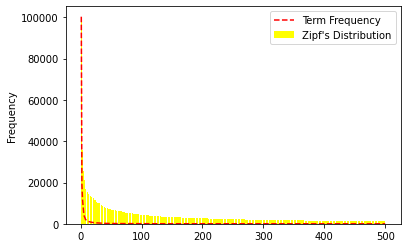

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(1, 501), top500.values(), color='yellow')
plt.plot(range(1, 501), expected_zipf, color='red', linestyle='--')
plt.ylabel('Frequency')
plt.legend(["Zipf's Distribution", 'Term Frequency'])
plt.show()

# **MODULE - 2**

In [ ]:
!pip install pyldavis

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 40.0 MB/s 
     |████████████████████████████████| 15.7 MB 261 kB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=179784d520bd09ec167e27a64d09aa5f80f9fb34ec7fe6277839f70dbec660c7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

**<h2> Importing libraries</h2>**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np

import string
import spacy
nlp = spacy.load('en_core_web_sm')

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


**<h2> Google Drive Authetication</h2>**

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have defined the path of our preprocessed review_books dataset stored in the google drive

In [ ]:
path ="/content/drive/MyDrive/reviews_Books_50K.csv"


**Reading data**

In [ ]:
import pandas as pd
df = pd.read_csv(path)

We have used the data presented in the reviewText column for training our model


In [ ]:
text_list=df['reviewText'].tolist()

We have used the inbuild stopwords.words function from nltk library to remove these stopwords from reviewText list

In [ ]:
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Removing stop words from reviewText corpus**

In [ ]:
# function to remove stopwords
def removeStopwords(reviewText):
    reviewText = str(reviewText)
    textArr = reviewText.split(' ')
    textAfterRemoving = " ".join([i for i in textArr if i not in stop_words])
    return textAfterRemoving

# remove stopwords from the text
df['text']=df['reviewText'].apply(removeStopwords)

**Lemmatization**


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       lemmatized_output = []
       for sentence in texts:
             doc = nlp(sentence) 
             lemmatized_output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return lemmatized_output

**Creating the tokenized review**

In [ ]:
reviewText_list=df['text'].tolist()
print(reviewText_list[1])
tokenized_reviews = lemmatization(reviewText_list)
print(tokenized_reviews[1])

This one must books. It masterpiece spirituality. I'll first admit, literary quality much. It rather simplistically written, message behind powerful read it. It take enlightenment.
['one', 'spirituality', 'literary', 'quality', 'message', 'powerful', 'enlightenment']


**Create doc term matrix from the list of texts**

In [ ]:
reviewDictionary = corpora.Dictionary(tokenized_reviews)
reviewCorpusMatrix = [reviewDictionary.doc2bow(rev) for rev in tokenized_reviews]

We have used LdaModel from genism library for topic modelling with following parameters <br>
<br>
*  <b>corpus</b> : stream of document vector (reviewCorpusMatrix)
*  <b> id2word</b> : used to map word IDs to words and determine the vocabulary size, as well as for debugging and topic printing.
* <b> num_topics </b>: number of requested latent topics to be extracted from the training corpus
* <b> chunksize</b> : corpus chunk on which the inference step will be performed. 

We have used 100 iterations and chunksize of 1000 for training our model 

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=reviewCorpusMatrix, id2word=reviewDictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

**Visualization**

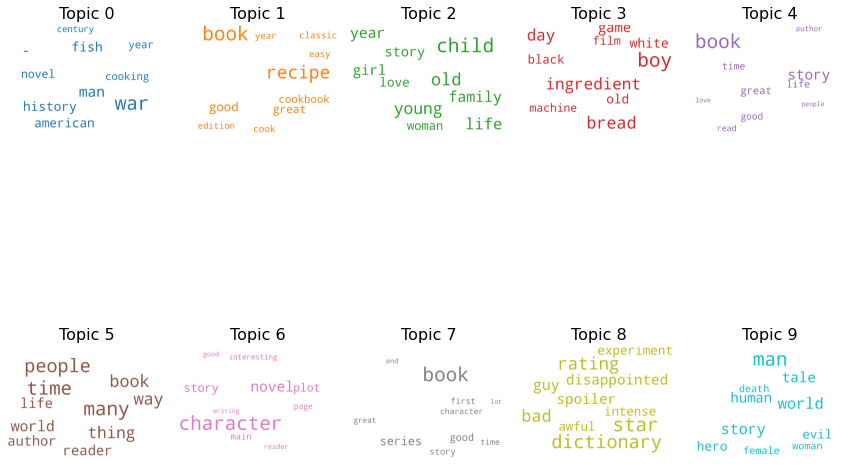

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
reviewCloud = WordCloud(stopwords=stop_words,background_color='white',width=2500,height=1800,max_words=10,
                  colormap='tab10',color_func=lambda *args, **kwargs: cols[i],prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    reviewCloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(reviewCloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

If we see the word cloud of the Dominant Topic list,let say for <b>topic 1</b> it consists of words like <b>recipe, cookbook</b> with highest probability of occurence and we can conclude that it is relted to cooking/cookery book reviews. <b> Topic 2</b> consistes of words like <b>child,young,girl,family, woman, life </b> .Looking at these keywords, we can conclude that this topics is related to family/charecters aspect present in the story.Likewise <b> topic 8</b> consistes of important keyword like <b>rating, disappointed,star,bad,awful,intense,spoiler</b> which might be related to the reader's experience.
Though few of the topics make sense, but this is not the case for all.

**Visualization**

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, reviewCorpusMatrix, reviewDictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.145539  0.008074       1        1  25.558298
7     -0.256760 -0.061391       2        1  16.012786
4     -0.229479  0.017234       3        1  11.151985
6     -0.114002 -0.022872       4        1   9.057516
2      0.052317  0.168748       5        1   8.244571
0      0.165853  0.177645       6        1   8.114561
9      0.151781  0.195580       7        1   7.453638
1     -0.092350 -0.109479       8        1   6.673101
3      0.215697 -0.081163       9        1   5.677229
8      0.252483 -0.292377      10        1   2.056316, topic_info=           Term          Freq         Total Category  logprob  loglift
0          book  98821.000000  98821.000000  Default  30.0000  30.0000
1051  character  26309.000000  26309.000000  Default  29.0000  29.0000
246       story  32815.000000  32815.000000  Default  28.0000  28.0000
768       novel  12913.000000  12913.000000  Default  27.0000  27.0000
571      series  12480.000000  12480.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
703        none    231.654412    853.528665  Topic10  -5.1027   2.5801
1786     ending    263.973826   2431.513515  Topic10  -4.9721   1.6638
3120  direction    209.874880    681.570600  Topic10  -5.2014   2.7064
743       crazy    198.711021    454.466901  Topic10  -5.2561   3.0570
2502     People    191.854702    342.059089  Topic10  -5.2912   3.3060

[622 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5335      3  0.994424      #
154       1  0.276911      -
154       2  0.092917      -
154       4  0.158005      -
154       6  0.440895      -
...     ...       ...    ...
125       6  0.139079   year
125       8  0.116890   year
125       9  0.038930   year
510       5  0.857322  young
510       7  0.142576  young

[976 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 5, 7, 3, 1, 10, 2, 4, 9])

For each dominant topic, we can see the top 30 most representative keywords.

**Perplexity and coherence score calculation**

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(reviewCorpusMatrix,total_docs=50000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherenceModelLda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=reviewDictionary ,
                                   coherence='c_v')
coherenceLda = coherenceModelLda.get_coherence()
print('\nCoherence Score: ', coherenceLda)


Perplexity:  -7.716029833460886

Coherence Score:  0.399160664338294


<b>Perplexity </b> is a statistical measure of how well a probability model predicts a sample.Lower perplexity score (more negative value) implies a good topic model, i.e. one that is good at predicting the words that appear in new documents.<br><br>

<b>Coherence score </b>measures how interpretable the topics are.These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [ ]:
def computeCoherenceValues(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

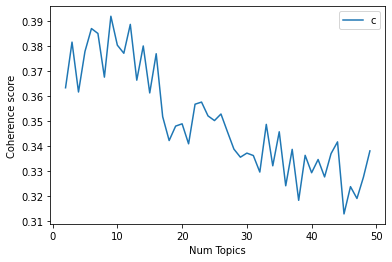

In [ ]:
model_list, coherence_values = computeCoherenceValues(dictionary=reviewDictionary, 
                                                      corpus=reviewCorpusMatrix,
                                                      texts=tokenized_reviews, start=2, limit=50, step=1)
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3633
Num Topics = 3  has Coherence Value of 0.3816
Num Topics = 4  has Coherence Value of 0.3616
Num Topics = 5  has Coherence Value of 0.3779
Num Topics = 6  has Coherence Value of 0.3871
Num Topics = 7  has Coherence Value of 0.3851
Num Topics = 8  has Coherence Value of 0.3676
Num Topics = 9  has Coherence Value of 0.392
Num Topics = 10  has Coherence Value of 0.3804
Num Topics = 11  has Coherence Value of 0.3772
Num Topics = 12  has Coherence Value of 0.3887
Num Topics = 13  has Coherence Value of 0.3664
Num Topics = 14  has Coherence Value of 0.3801
Num Topics = 15  has Coherence Value of 0.3613
Num Topics = 16  has Coherence Value of 0.377
Num Topics = 17  has Coherence Value of 0.3517
Num Topics = 18  has Coherence Value of 0.3422
Num Topics = 19  has Coherence Value of 0.348
Num Topics = 20  has Coherence Value of 0.3489
Num Topics = 21  has Coherence Value of 0.3409
Num Topics = 22  has Coherence Value of 0.3567
Num Topics = 23  has Coh

Now here we can see the model with topic numbers 9 has the highest coherence score.So this is the most optimal model.

In [ ]:
# Select the model and print the topics
optimalModel = model_list[7]
model_topics = optimalModel.show_topics(formatted=False)
optimalModel.print_topics(num_words=10)

[(0,
  '0.036*"recipe" + 0.015*"man" + 0.014*"old" + 0.012*"child" + 0.011*"woman" + 0.010*"young" + 0.010*"family" + 0.010*"year" + 0.009*"girl" + 0.008*"death"'),
 (1,
  '0.156*"book" + 0.035*"series" + 0.031*"story" + 0.029*"good" + 0.017*"character" + 0.017*"great" + 0.015*"first" + 0.014*"end" + 0.013*"time" + 0.011*"page"'),
 (2,
  '0.055*"character" + 0.046*"book" + 0.013*"series" + 0.012*"novel" + 0.012*"time" + 0.011*"story" + 0.010*"first" + 0.010*"plot" + 0.010*"thing" + 0.009*"chapter"'),
 (3,
  '0.017*"novel" + 0.010*"book" + 0.008*"many" + 0.008*"bread" + 0.008*"work" + 0.008*"word" + 0.007*"ingredient" + 0.006*"good" + 0.005*"food" + 0.005*"much"'),
 (4,
  '0.018*"book" + 0.009*"world" + 0.009*"people" + 0.009*"many" + 0.007*"time" + 0.007*"philosophy" + 0.007*"society" + 0.006*"history" + 0.005*"work" + 0.005*"year"'),
 (5,
  '0.038*"story" + 0.032*"life" + 0.016*"man" + 0.013*"novel" + 0.009*"reader" + 0.009*"tale" + 0.009*"time" + 0.008*"book" + 0.008*"human" + 0.008*

Here we can see top 10 topics with the probability of most important words. 

**Visualization with the optimal model**

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimalModel, reviewCorpusMatrix, reviewDictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.118750  0.010448       1        1  16.192646
6      0.094810 -0.072203       2        1  15.508044
1      0.212018 -0.049613       3        1  14.510219
0     -0.130653 -0.096832       4        1  12.510538
5     -0.063702 -0.117258       5        1  12.227436
4     -0.139571  0.131490       6        1  10.424359
8      0.083317  0.140094       7        1   6.602775
3     -0.050181  0.126070       8        1   6.458168
7     -0.124786 -0.072197       9        1   5.565816, topic_info=           Term           Freq          Total Category  logprob  loglift
0          book  100130.000000  100130.000000  Default  30.0000  30.0000
5228     recipe    8425.000000    8425.000000  Default  29.0000  29.0000
1051  character   25078.000000   25078.000000  Default  28.0000  28.0000
571      series   13511.000000   13511.000000  Default  27.0000  27.0000
1754        war    5993.000000    5993.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
44       author     463.922891   10259.619460   Topic9  -5.4040  -0.2077
17         time     426.593104   20150.695104   Topic9  -5.4878  -0.9666
839        fact     350.883761    3720.348399   Topic9  -5.6832   0.5274
125        year     341.173924   10060.649039   Topic9  -5.7113  -0.4955
264        good     353.461649   19741.289385   Topic9  -5.6759  -1.1342

[768 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
154       1  0.267305          -
154       2  0.083310          -
154       3  0.021660          -
154       4  0.098305          -
154       5  0.010949          -
...     ...       ...        ...
510       7  0.003025      young
510       8  0.009074      young
510       9  0.014720      young
3985      8  0.990809  youngster
7337      9  0.993753          z

[2424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 1, 6, 5, 9, 4, 8])

<b>Top 20 representative sentences for each dominant topic</b>

In [ ]:
#Dominant topic and its percentage contribution in each document

def format_topics_sentences(ldamodel=None, corpus=reviewCorpusMatrix, texts=tokenized_reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=reviewCorpusMatrix, texts=tokenized_reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.4607,"book, series, good, story, first, time, charac...","[inspiring, book, question, moral]"
1,1,5.0,0.8875,"many, time, people, book, way, thing, world, r...","[one, spirituality, literary, quality, message..."
2,2,5.0,0.6692,"many, time, people, book, way, thing, world, r...","[book, reflection, life, way, right, thing, sh..."
3,3,5.0,0.3689,"many, time, people, book, way, thing, world, r...","[book, revival, metaphysical, turbulent, profo..."
4,4,1.0,0.4332,"book, recipe, good, great, cookbook, cook, yea...","[timeless, classic, title, excellent, style, c..."
5,5,3.0,0.5117,"boy, bread, ingredient, day, game, white, old,...","[reading, mind, pool, water, cool, quiet, moss..."
6,6,5.0,0.9357,"many, time, people, book, way, thing, world, r...","[poetry, spiritual, visual, beauty, life, famo..."
7,7,5.0,0.9357,"many, time, people, book, way, thing, world, r...","[deep, dramatic, verse, heart, soul, truth, an..."
8,8,4.0,0.4416,"book, story, great, life, time, good, read, au...","[timeless, classic, year, gift, time, address,..."
9,9,5.0,0.5388,"many, time, people, book, way, thing, world, r...","[amazing, work, extensive, use, biblical, imag..."


<b>df_dominant_topic</b> dataframe consists of all the dominant topics along with their document number, topic percentage contribution,keywords and the representative texts. We have displayed the most significant sentence for each topic based on its topic percentage contribution. 

In [ ]:

def representativeTopic(df_dominant_topic):
  df_res = pd.DataFrame()
  for i in range(1,10):
    topic_num = i*1.0
    dom_topic = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic_num]
    dom_topic_top_20 = dom_topic.sort_values(by = 'Topic_Perc_Contrib', ascending = False)
    print(dom_topic_top_20.head(20))
    print("*****************************************************************************************")
    new_df = dom_topic_top_20.head(20)
    df_res = df_res.append(new_df)
  df_res.to_excel("topic_keywords.xlsx",index=False)
representativeTopic(df_dominant_topic)

       Document_No  ...                                               Text
44202        44202  ...  [health, CATALOGUED, MORE, informative, book, ...
43882        43882  ...  [today, recipe, book, lot, information, topic,...
49745        49745  ...  [book, great, product, lot, information, learn...
48895        48895  ...  [fabulous, collection, easy, recipe, food, gro...
13647        13647  ...  [year, single, volume, nice, great, price, nic...
49056        49056  ...  [worth, price, large, size, small, picture, in...
13799        13799  ...  [nice, quality, wonderful, literary, classic, ...
19344        19344  ...  [vast, information, easy, fallow, instruction,...
26452        26452  ...  [student, date, great, condition, content, boo...
14260        14260  ...  [good, condition, good, pricing, nice, cover, ...
48736        48736  ...  [gift, recipe, date, book, nice, picture, good...
49454        49454  ...  [book, helpful, word, many, word, letter, word...
49154        49154  ...  